# Breast Cancer Wisconsin Data (BCDW)

***Candidate Name:*** Chatzimoschou Angeliki,
***Job Position:*** Data Scientist,
***Company:*** JP Morgan,
***Location:*** Glasgow (UK)

## Part 1
### Assignment Questions

**i)** What are the mean, median and standard deviation of the “perimeter (mean)” feature?

**ii)** Is the first feature in this data set (“radius (mean)”) normally distributed? If not, what might be a more appropriate distribution? Please quantitatively define you answer.

[Answers](#Part_1-Answers)

## Part 2
### Introduction
**iii)** This assignment aims at predicting as good as possible the 'Malignant' or 'Benign' tumor cells concerning UCI open source dataset: Breast Cancer Wisconsin Data. It consists of the following main sections:

1. [First Quickview](#First-Quickview)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Visual Exploration](#Visual-Exploration) 
4. [Checking Correlations](#Checking-Correlations)
5. [Binary Classification Methods](#Binary-Classification-Methods)
6. [Conclusion](#Conclusion)
7. [Future Steps](#Future-Steps)

<br>Importing packages:

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
import time

warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.style.use("ggplot")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

**Data Information:**

i. Number of instances: 569 

ii. Number of attributes: 32 (ID, diagnosis, 30 real-valued input features)

iii. Attribute information

    1) ID number
    2)Diagnosis (M = malignant, B = benign)
    3 - 32) Ten real-valued features are computed for each cell nucleus:
        a) radius (mean of distances from center to points on the perimeter)
        b) texture (standard deviation of gray-scale values)
        c) perimeter
        d) area
        e) smoothness (local variation in radius lengths)
        f) compactness (perimeter^2 / area - 1.0)
        g) concavity (severity of concave portions of the contour)
        h) concave points (number of concave portions of the contour)
        i) symmetry 
        j) fractal dimension ("coastline approximation" - 1)

iv) Missing Values: None

Features that belong to similar groupings(Mean, Standard Error, "Worst" or Largest) are tagged as such in the feature names (e.g., _mean, _se, _worst).
A Mean feature represents the mean of all the cells and similar applies to the features of the other 2 groups.
The target column signifies whether a tumor cell is classified as Malignant or Benign.

<a id='First-Quickview'></a>
To begin with, let's build the column names in the appropriate order and let's have a quick view, so as to confirm that the dimensions are as mentioned and confirm that we have no Nulls.

In [3]:
# build df's feature names and in appropriate order as stated in wdbc.data file
col_names = ['id', 'diagnosis']
var_names = [y + '_' + x for x in ['mean', 'se', 'worst'] for y in ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'concavity', 'concave_points',
                                     'symmetry', 'fractal_dimension'] ]
col_names.extend(var_names)
print(col_names)

['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [4]:
# load data and print first 5 rows
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/\
breast-cancer-wisconsin/wdbc.data', header = None, names = col_names)
df.head() 

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.00,0.12,0.28,0.30,0.15,0.24,0.08,1.09,0.91,8.59,153.40,0.01,0.05,0.05,0.02,0.03,0.01,25.38,17.33,184.60,2019.00,0.16,0.67,0.71,0.27,0.46,0.12
1,842517,M,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,0.18,0.06,0.54,0.73,3.40,74.08,0.01,0.01,0.02,0.01,0.01,0.00,24.99,23.41,158.80,1956.00,0.12,0.19,0.24,0.19,0.28,0.09
2,84300903,M,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,0.21,0.06,0.75,0.79,4.58,94.03,0.01,0.04,0.04,0.02,0.02,0.00,23.57,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09
3,84348301,M,11.42,20.38,77.58,386.10,0.14,0.28,0.24,0.11,0.26,0.10,0.50,1.16,3.44,27.23,0.01,0.07,0.06,0.02,0.06,0.01,14.91,26.50,98.87,567.70,0.21,0.87,0.69,0.26,0.66,0.17
4,84358402,M,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,0.18,0.06,0.76,0.78,5.44,94.44,0.01,0.02,0.06,0.02,0.02,0.01,22.54,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08


In [5]:
# check df dimensions -> as described
df.shape

(569, 32)

In [6]:
# remove any potential duplicate rows
df = df.drop_duplicates()

In [7]:
# check if there were any duplicates -> No
df.shape

(569, 32)

In [8]:
# verify that there are no NAs
df.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

We have 32 variables and 569 rows, No duplicated entries and No Nulls.

After loading the data and performing some quick quality checks, let's answer the first Part of the Assignment:
<a id='Part_1-Answers'></a>

The Mean of 'perimeter_mean' is: 91.97
The Median of 'perimeter_mean' is: 86.24
The Standard Deviation of 'perimeter_mean' is: 24.30


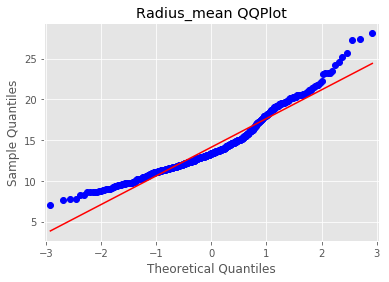

Statistics=0.941, p=0.000
Variable Distribution does not seem to be Gaussian (we reject H0)


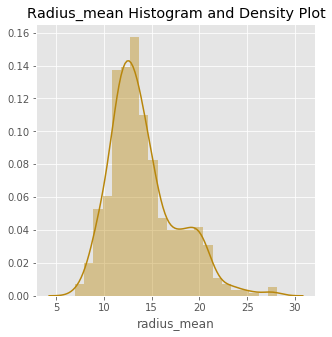

In [9]:
print("The Mean of 'perimeter_mean' is: %.2f" 
                              %(df['perimeter_mean'].mean()))
print("The Median of 'perimeter_mean' is: %.2f" 
                              %(df['perimeter_mean'].median()))
print("The Standard Deviation of 'perimeter_mean' is: %.2f" 
                              %(df['perimeter_mean'].std()))

qqplot(df['radius_mean'], line = 's')
plt.title('Radius_mean QQPlot')   
plt.show()

# Shapiro-Wlkinson normality test
stat, p = shapiro(df['radius_mean'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Variable Distribution seems to be Gaussian (we fail to reject H0)')
else:
    print('Variable Distribution does not seem to be Gaussian (we reject H0)')
    
# radius_mean Histogram
fig = plt.figure(figsize = (5, 5))
sns.distplot(df['radius_mean'], color = 'darkgoldenrod')
plt.title('Radius_mean Histogram and Density Plot')   
plt.show()

Observing the Histogram of 'radius_mean', we may conclude that we have to deal with a Mixture distribution. Since we can't assume Normality, I would try to estimate the distribution via a non-parametric kernel density estimator. I would get the estimated pdf and then estimate the respective mean and std.

<a id='Exploratory-Data-Analysis'></a>
### Exploratory Data Analysis

Let's first delete the ID feature as it offers no useful information and check if the remainders have the appropriate data type.

In [13]:
# delete ID variable
df = df.drop(['id'], axis = 1)

# check data type
df.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave_points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave_points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave_points_worst

<br>**Quick Descriptive Statistical Summary**

In [14]:
# get quick descriptives -> we need to normalize, since different magnitude of feature values
df.describe(include = 'all')

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00,569.00
unique,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,B,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,357,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,NaN,14.13,19.29,91.97,654.89,0.10,0.10,0.09,0.05,0.18,0.06,0.41,1.22,2.87,40.34,0.01,0.03,0.03,0.01,0.02,0.00,16.27,25.68,107.26,880.58,0.13,0.25,0.27,0.11,0.29,0.08
std,NaN,3.52,4.30,24.30,351.91,0.01,0.05,0.08,0.04,0.03,0.01,0.28,0.55,2.02,45.49,0.00,0.02,0.03,0.01,0.01,0.00,4.83,6.15,33.60,569.36,0.02,0.16,0.21,0.07,0.06,0.02
min,NaN,6.98,9.71,43.79,143.50,0.05,0.02,0.00,0.00,0.11,0.05,0.11,0.36,0.76,6.80,0.00,0.00,0.00,0.00,0.01,0.00,7.93,12.02,50.41,185.20,0.07,0.03,0.00,0.00,0.16,0.06
25%,NaN,11.70,16.17,75.17,420.30,0.09,0.06,0.03,0.02,0.16,0.06,0.23,0.83,1.61,17.85,0.01,0.01,0.02,0.01,0.02,0.00,13.01,21.08,84.11,515.30,0.12,0.15,0.11,0.06,0.25,0.07
50%,NaN,13.37,18.84,86.24,551.10,0.10,0.09,0.06,0.03,0.18,0.06,0.32,1.11,2.29,24.53,0.01,0.02,0.03,0.01,0.02,0.00,14.97,25.41,97.66,686.50,0.13,0.21,0.23,0.10,0.28,0.08
75%,NaN,15.78,21.80,104.10,782.70,0.11,0.13,0.13,0.07,0.20,0.07,0.48,1.47,3.36,45.19,0.01,0.03,0.04,0.01,0.02,0.00,18.79,29.72,125.40,1084.00,0.15,0.34,0.38,0.16,0.32,0.09


Observing the table, we may conclude that there is need for normalization, as our data have different magnitude and don't share similar ranges.



<a id= 'Visual-Exploration'></a>

### Visual Exploration
#### Descriptive Histograms for All Features

Let's visualize the distribution of each feature grouped by our target variable: Diagnosis.

Text(0.5, 1.0, 'Diagnosis Frequency Plot')

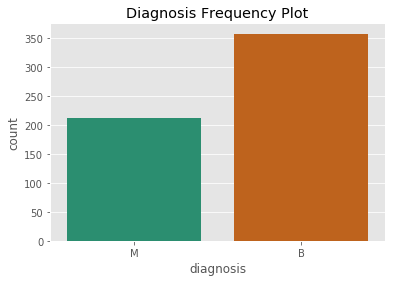

In [15]:
# response plot
sns.countplot(df['diagnosis'], palette = "Dark2").set_title('Diagnosis Frequency Plot')

In this sample dataset, Benign tumor cells seem to occur more frequently.

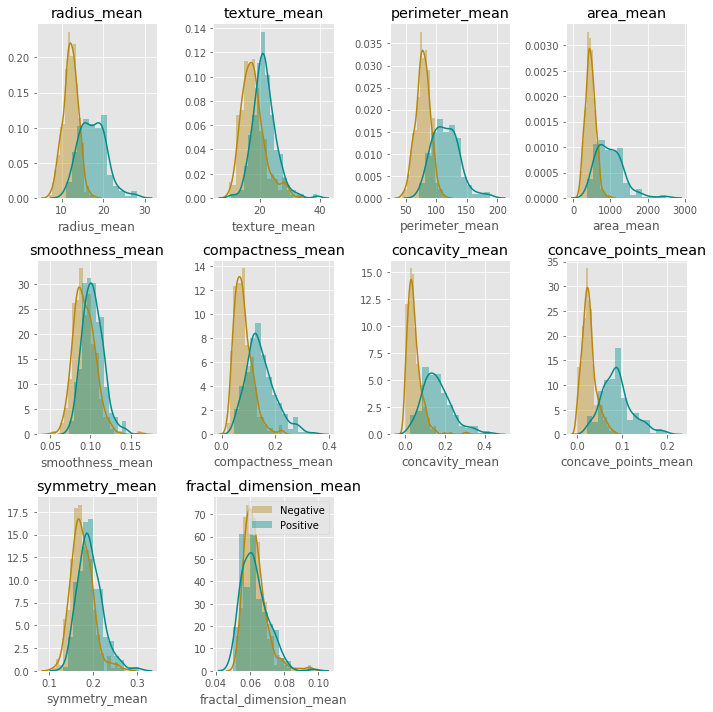

In [16]:
df_B = df.query('diagnosis == "B"')
df_M = df.query('diagnosis == "M"')

# keep only the _mean predictors
var_means = df.columns[df.columns.str.contains('_mean')]

# Multiple Histograms grouped by Diagnosis
fig = plt.figure(figsize = (10, 10))

for i, b in enumerate(list(var_means)):    
    i += 1    
    plt.subplot(3, 4, i)
    sns.distplot(df_B[b], label = 'Negative', color = 'darkgoldenrod').set_title(b)
    sns.distplot(df_M[b], label = 'Positive', color = 'darkcyan').set_title(b)
    
plt.tight_layout()
plt.legend(loc = 'upper right')
plt.show()

Observing the Histograms of all Mean features, we may conclude that Malignant tumor cells (Positive class) are mainly characterized by bigger magnitude of values.

It looks like radius_mean, perimeter_mean, area_mean, concavity_mean and concave_points_mean are mostly separated between the classes of the target: Diagnosis.

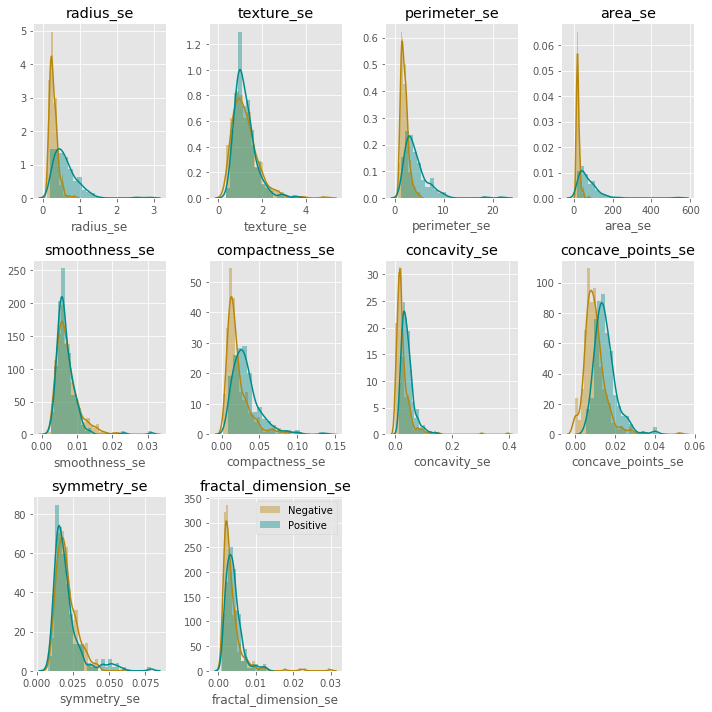

In [17]:
# keep only the _se predictors
var_se = df.columns[df.columns.str.contains('_se')]

# Multiple Histograms grouped by Diagnosis
f = plt.figure(figsize = (10, 10))

for i, b in enumerate(list(var_se)):    
    i += 1    
    plt.subplot(3, 4, i)
    sns.distplot(df_B[b], label = 'Negative', color = 'darkgoldenrod').set_title(b)
    sns.distplot(df_M[b], label = 'Positive', color = 'darkcyan').set_title(b)

plt.tight_layout()
plt.legend(loc = 'upper right')
plt.show()

Observing the Histograms of all SE features, we may conclude that there is a lot of overlapping between the classes of the target: Diagnosis.

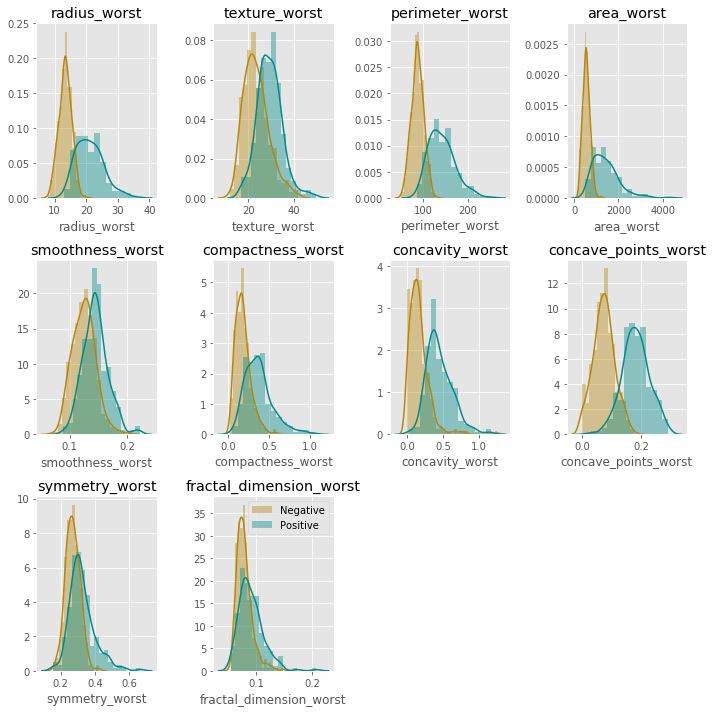

In [18]:
# keep only the _worst predictors
var_worst = df.columns[df.columns.str.contains('_worst')]

# Multiple Histograms grouped by Diagnosis
f = plt.figure(figsize = (10, 10))

for i, b in enumerate(list(var_worst)):    
    i += 1    
    plt.subplot(3, 4, i)
    sns.distplot(df_B[b], label = 'Negative', color = 'darkgoldenrod').set_title(b)
    sns.distplot(df_M[b], label = 'Positive', color = 'darkcyan').set_title(b)

plt.tight_layout()
plt.legend(loc = 'upper right')
plt.show()

Observing the Histograms of all Worst features, we may jump to similar conclusions as the Mean group of features.

#### Descriptive Boxplots for All Features
Next, let's also produce some Boxplots for every group.

Text(0.5, 1.0, 'All "_mean" features Boxplots grouped by Diagnosis')

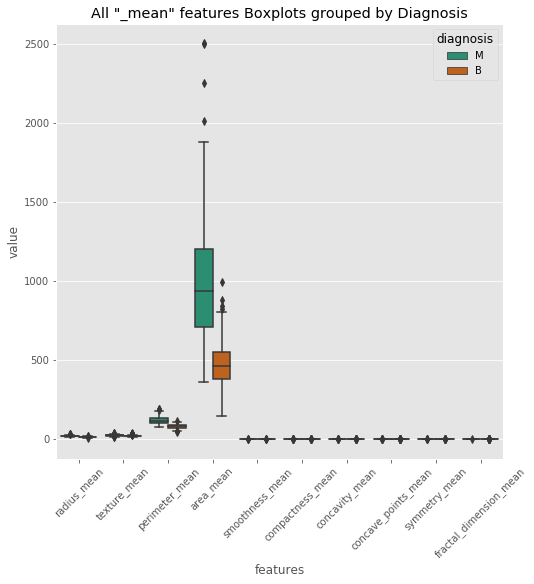

In [19]:
tmp = list(var_means)
tmp.append("diagnosis")

df_melt_mean = pd.melt(df[tmp], id_vars = "diagnosis",
                    var_name = "features",
                    value_name = 'value')

f = plt.figure(figsize = (8, 8))
sns.boxplot(x = "features", y = "value", hue = "diagnosis", palette = "Dark2", 
            data = df_melt_mean)
plt.xticks(rotation = 45)
plt.title('All "_mean" features Boxplots grouped by Diagnosis')


Text(0.5, 1.0, 'All "_se" features Boxplots grouped by Diagnosis')

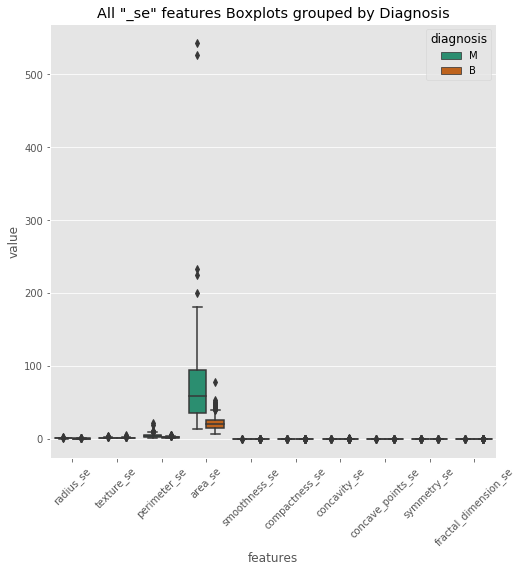

In [20]:
tmp = list(var_se)
tmp.append("diagnosis")

df_melt_se = pd.melt(df[tmp], id_vars = "diagnosis",
                    var_name = "features",
                    value_name = 'value')

f = plt.figure(figsize = (8, 8))
sns.boxplot(x = "features", y = "value", hue = "diagnosis", palette = "Dark2", 
            data = df_melt_se)
plt.xticks(rotation = 45)
plt.title('All "_se" features Boxplots grouped by Diagnosis')


Text(0.5, 1.0, 'All "_worst" features Boxplots grouped by Diagnosis')

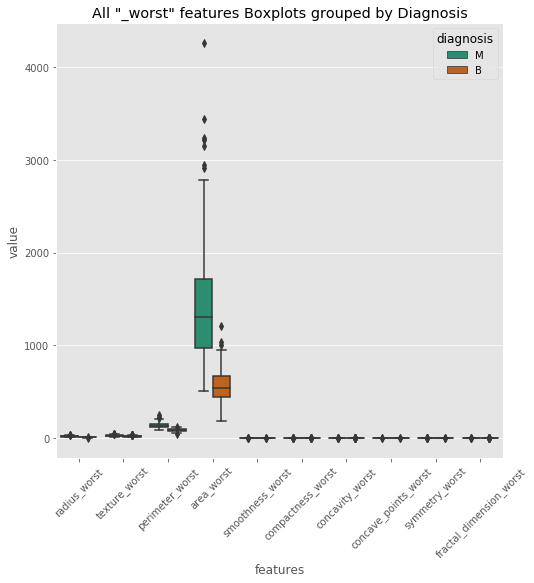

In [21]:
tmp = list(var_worst)
tmp.append("diagnosis")

df_melt_worst = pd.melt(df[tmp], id_vars = "diagnosis",
                    var_name = "features",
                    value_name = 'value')

f = plt.figure(figsize = (8, 8))
sns.boxplot(x = "features", y = "value", hue = "diagnosis", palette = "Dark2", 
            data = df_melt_worst)
plt.xticks(rotation = 45)
plt.title('All "_worst" features Boxplots grouped by Diagnosis')


It would be better to visualize all Perimeter and Area features separately from the rest of the features,
as they affect a lot the scale of the plot. However, just by this quick check, we may conclude that there are outlier in our variables and certainly Malignant tumor cells are characterized by greater median values, especially in features like: radius, texture, perimeter and area. 

Having separated our dataset in y(dependent variable) and x(independent variables), let's spot any Zero variance independent variables and remove them, as this would be mean that they carry no useful information (statistically insignificant) and check the Correlations between them.

In [22]:
# y represents the response and x represents the predictors
y = df.diagnosis 
x = df.drop(['diagnosis'], axis = 1)

In [23]:
# zero variance check on the predictors
selector = VarianceThreshold(threshold = 0.0)
selector.fit_transform(x)
x_tmp = x[x.columns[selector.get_support(indices = True)]]
x_tmp.shape # no change

(569, 30)

Since the number of independent variables remains the same, no predictor suffers from zero variance.

<a id= 'Checking-Correlations'></a>
### Checking the correlations between every independent feature in our dataset

Acorrelation plot is appropriate to show us the strength and the kind of the relationship between two variables.
The values may vary from -1 to 1.

Meaning of 1: Two variables are positively correlated with each other. When the values of the one variable increase, then the values of the other variable increase as well (like radius_mean and perimeter_mean).

Meaning of -1: Two variables are negatively correlated with each other. When the values of the one variable increase, then the values of the other variable decrease.

Meaning of 0: There is no correlation between two variables (like radius_mean and fractal_dimension_worst)


Text(0.5, 1.0, 'Correlation Plot: check')

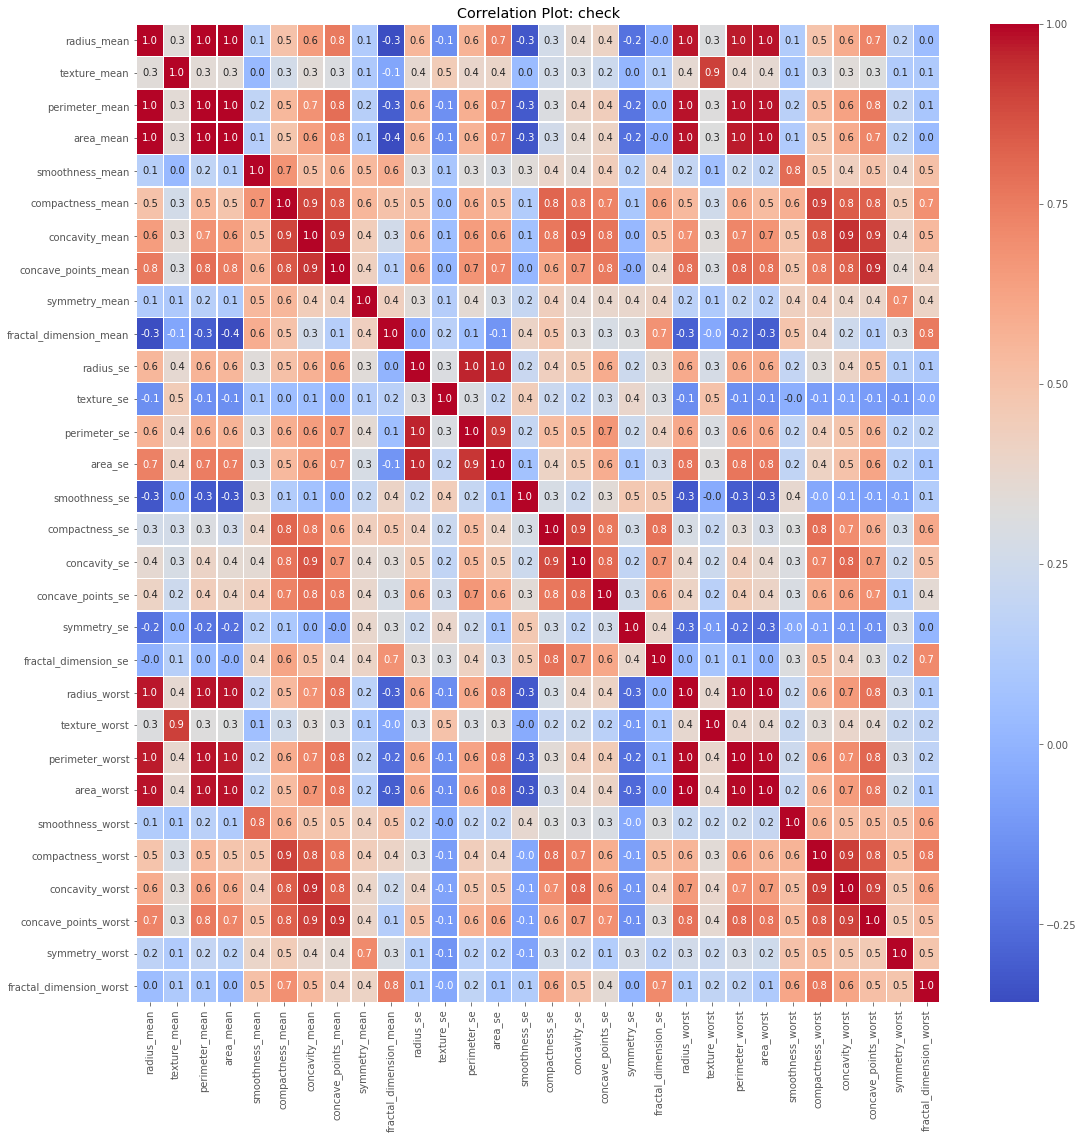

In [24]:
# correlation plot
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(x.corr(method = 'spearman'), annot = True, linewidths = 0.5,
            fmt = "0.1f", cmap = 'coolwarm', ax = ax)
plt.title('Correlation Plot: check')


The correlation plot above is built using the Spearman correlation coefficients, because in cases when the relationship between two variables is not linear, spearman's correlation tends to better estimate the strength of relationship and is more robust towards outliers than Pearson.


Observing the plot, we may conclude that we may remove features like: 'area_worst', 'perimeter_worst', 'radius_worst', 'concave_points_mean', 'area_mean', 'perimeter_mean', 'texture_worst', 'smoothness_worst', 'concavity_se', 'compactness_se', 'concave_points_worst', 'fractal_dimension_worst', 'concavity_worst', 'compactness_worst', 'concavity_mean', 'area_se' and
'perimeter_se', as they share high correlation coefficients with their respective pairs (equal or higher than 0.8).

Text(0.5, 1.0, 'Correlation Plot: final check')

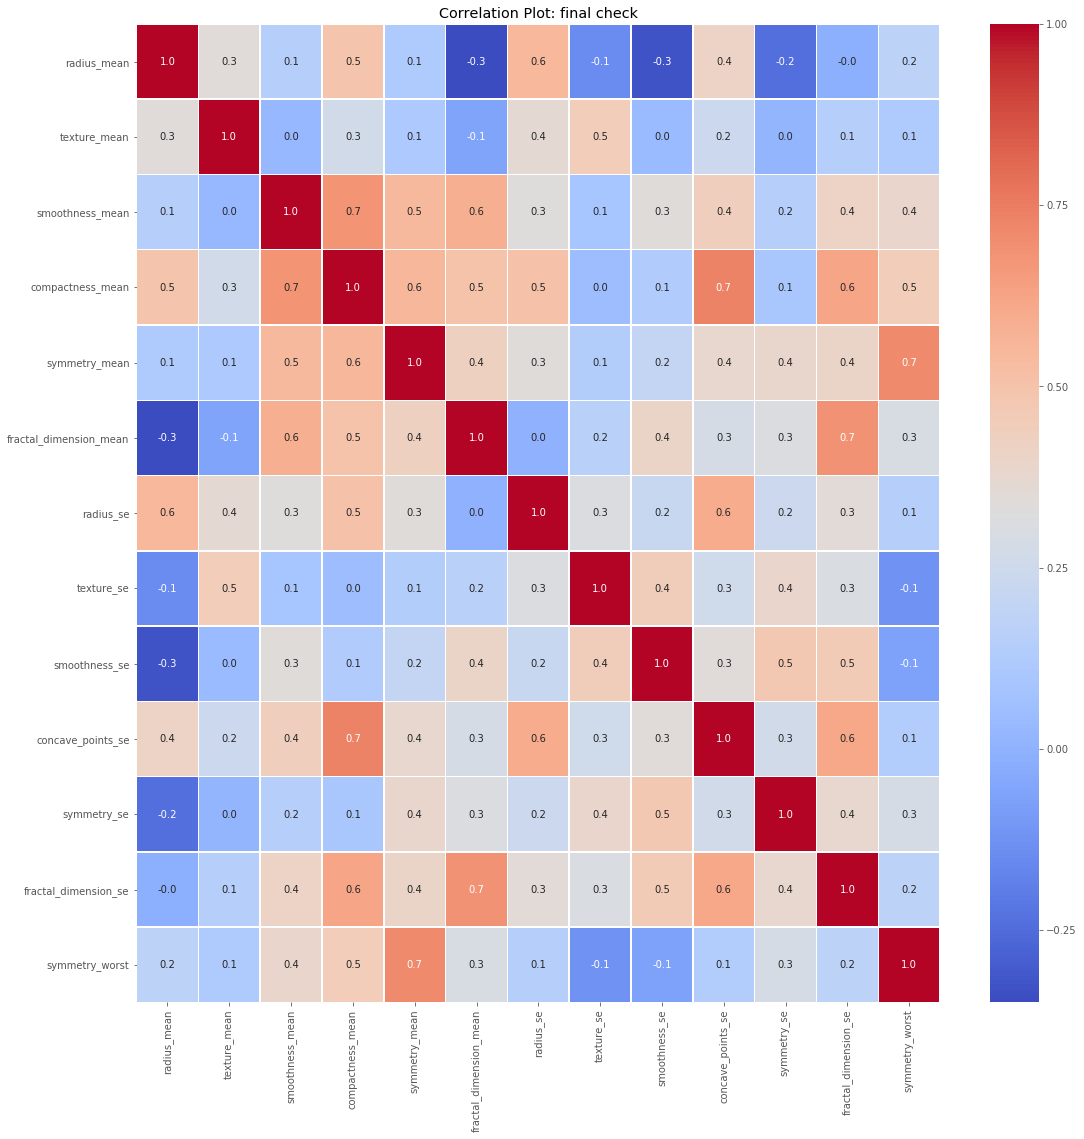

In [25]:
# drop the high correlated features (corr >= 0.8)
vars_to_drop = ['area_worst', 'perimeter_worst', 'radius_worst', 'concave_points_mean', 
                'area_mean', 'perimeter_mean', 'texture_worst', 'smoothness_worst', 
                'concavity_se', 'compactness_se', 'concave_points_worst', 'fractal_dimension_worst',
                'concavity_worst', 'compactness_worst', 'concavity_mean', 'area_se',
                'perimeter_se']
x = x.drop(vars_to_drop, axis = 1)

f, ax = plt.subplots(figsize= (18, 18))
sns.heatmap(x.corr(method = 'spearman'), annot = True, linewidths =.5, fmt = ".1f", 
            cmap = 'coolwarm', ax = ax)
plt.title('Correlation Plot: final check')


Now that we have resolved the issue of Multicolinearity, let's move on to the modelling process and create some Binary Classifiers.

<a id='Binary-Classification-Methods'></a>
### Binary Classification Methods

First, we need to recode our response to 1 for Malignant and 0 for Benign for computation's sake. Then we need to randomly split the Dependent and Independent variables into Train and Test (80%-20% respectively). Finally, since our variables share different ranges of values, we will normalize them (via Robust Scaler, as we have outliers), in order to avoid the issue of having features dominating the objective function and make the classifier unable to learn from the rest of the features correctly. Then we will implement several classifications models (KNN, Logistic Regression, Lasso Regression and Random Forests) produce the respective confusion matrices and the derivative metrics.

In [26]:
# recode response to 0, 1 for faster computations and turn to Categorical
df['diagnosis'] = df['diagnosis'].map({'M':"1", 'B':"0"})
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.00,0.12,0.28,0.30,0.15,0.24,0.08,1.09,0.91,8.59,153.40,0.01,0.05,0.05,0.02,0.03,0.01,25.38,17.33,184.60,2019.00,0.16,0.67,0.71,0.27,0.46,0.12
1,1,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,0.18,0.06,0.54,0.73,3.40,74.08,0.01,0.01,0.02,0.01,0.01,0.00,24.99,23.41,158.80,1956.00,0.12,0.19,0.24,0.19,0.28,0.09
2,1,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,0.21,0.06,0.75,0.79,4.58,94.03,0.01,0.04,0.04,0.02,0.02,0.00,23.57,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09
3,1,11.42,20.38,77.58,386.10,0.14,0.28,0.24,0.11,0.26,0.10,0.50,1.16,3.44,27.23,0.01,0.07,0.06,0.02,0.06,0.01,14.91,26.50,98.87,567.70,0.21,0.87,0.69,0.26,0.66,0.17
4,1,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,0.18,0.06,0.76,0.78,5.44,94.44,0.01,0.02,0.06,0.02,0.02,0.01,22.54,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08


In [27]:
# Split df into train-test datasets (80% - 20% respectively)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size = 0.8,  random_state = 42)

In [28]:
# Normalization
scaler = RobustScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc = pd.DataFrame(X_train_sc, columns = X_train.columns)
X_test_sc = pd.DataFrame(X_test_sc, columns = X_train.columns)

### K_Nearest_Neighbors

**k-nearest neighbors(k-NN)** is a non-parametric method used for classification and regression. In both cases, the input consists of the k closest training examples in the feature space. In k-NN classification, an object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors.

<br> **GridSearchCV** implements a 'fit' and 'score' method. 
It is a quick-win method as the parameters of the estimator used, are optimized by cross-validated grid-search, over a parameter grid by performing exhaustive search on them. The main reason of model validation is to estimate how the model will generalize to new data and avoid overfitting. We will implement the usual 10-fold CV.

In [29]:
KNN = KNeighborsClassifier()
KNN_params = {'n_neighbors':[2,5,10,15]}
kfold = KFold(n_splits = 10, shuffle = True)
KNN_grid = GridSearchCV(KNN, KNN_params)

# Run cross validation
cv_KNN = cross_val_score(KNN_grid, X_train_sc, Y_train, cv = kfold, 
                                   scoring = 'accuracy')

print('KNN Classifier Mean Accuracy Score in Cross-Validation: %0.2f \
and SD: %0.2f' %(cv_KNN.mean(), cv_KNN.std()))
KNN_grid.fit(X_train_sc, Y_train)

preds_KNN = KNN_grid.predict(X_test_sc)

print('Accuracy of KNN classifier on test set: {:0.2f}'.format(accuracy_score(preds_KNN, Y_test))) 

# Check best parameters
print('Best Parameters of KNN classifier: {}'.format(KNN_grid.best_params_))

KNN Classifier Mean Accuracy Score in Cross-Validation: 0.93 and SD: 0.03
Accuracy of KNN classifier on test set: 0.93
Best Parameters of KNN classifier: {'n_neighbors': 5}


#### Compute Confusion Matrix and precision, recall, F-measure and support

The metrics we used to evaluate our predictive performance are coming from the elements of the confusion matrix and are the following:    

   **Sensitivity (Recall)**= True Positive Rate (TP/TP+FN), how many positive values of each class have been predicted          
                             correctly,

   **Precision**= Positive Predictive Rate(TP/TP+FP), It is the ability of the classifier to not label a sample as positive  when it is negative (what predicted positives are actually positives),
   
   **F-score**= weighted harmonic mean of the precision and recall, the closer to 1 the better. If F-score=1, it means that  
                 recall and precision are equally important,
                 
   **Support**= the number of occurrences of each class in 'target' variable



KNN Model Classification Report
              precision    recall  f1-score   support

           0       0.92      0.97      0.95        71
           1       0.95      0.86      0.90        43

   micro avg       0.93      0.93      0.93       114
   macro avg       0.93      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



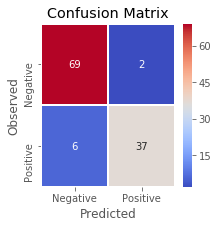

In [30]:
cm_KNN = pd.DataFrame(confusion_matrix(Y_test, preds_KNN), index = ['Negative', 'Positive'], 
                         columns = ['Negative', 'Positive'])

f, ax = plt.subplots(figsize = (3, 3))
sns.heatmap(cm_KNN, annot = True, linewidth = 1, cmap = 'coolwarm', ax = ax)
plt.title('Confusion Matrix')
plt.ylabel('Observed')
plt.xlabel('Predicted')
print('\n')
print('KNN Model Classification Report')
print(classification_report(Y_test, preds_KNN))

### Logistic Regression

**Logistic or logit regression** is a classification model where the dependent variable is categorical. Usually it takes values: "0" and "1". Logistic regression measures the relationship between the categorical dependent variable and the independent variables by estimating probabilities using a logistic function, which is the cumulative logistic distribution.

In [31]:
Y_train = Y_train.astype(int)

X_train_sc = sm.add_constant(X_train_sc)
start = time.time()
LogReg = sm.Logit(Y_train, np.asarray(X_train_sc))
LogReg = LogReg.fit()
end = time.time()
print('Execution time: %s seconds \n' % '{:.5}'.format(end-start))
LogReg.summary()

Optimization terminated successfully.
         Current function value: 0.069837
         Iterations 11
Execution time: 0.0044224 seconds 



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              diagnosis   No. Observations:                  455
Model:                          Logit   Df Residuals:                      441
Method:                           MLE   Df Model:                           13
Date:                Mon, 14 Oct 2019   Pseudo R-squ.:                  0.8941
Time:                        15:29:43   Log-Likelihood:                -31.776
converged:                       True   LL-Null:                       -300.17
                                        LLR p-value:                2.220e-106
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.2505      0.797     -5.332      0.000      -5.813      -2.688
x1             6.1632      1.802      3.421      0.001       2.632       9.694
x2             2.7271      0.776      3.512      0.000       1.205       4.249
x3             2.0140      1.179      1.708      0.088      -0.297       4.325
x4            -0.4939      1.686     -0.293      0.770      -3.798       2.810
x5            -2.8185      1.103     -2.556      0.011      -4.980      -0.657
x6             0.7597      1.420      0.535      0.593      -2.024       3.544
x7             3.7112      1.157      3.208      0.001       1.444       5.979
x8             0.8006      0.669      1.196      0.232      -0.511       2.112
x9             0.4270      0.671      0.636      0.525      -0.888       1.742
x10            3.4547      1.177      2.936      0.003       1.148       5.761
x11           -3.9794      0.937     -4.248      0.000      -5.816      -2.143
x12           -2.1120      0.924     -2.286      0.022      -3.923      -0.301
x13            7.3529      1.661      4.426      0.000       4.097      10.609
==============================================================================

Possibly complete quasi-separation: A fraction 0.55 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

From the summary table above, we see that we have some features which are statistically not significant (p-value > 0.05) towards our response variable. However, the pseudo-R-squared is high enough (89.4%) to state that our model is interpreting well  the variability of our dataset. 

#### Logistic Regression's odds:

In [32]:
np.asarray(np.exp(LogReg.params))

array([1.42567112e-02, 4.74937020e+02, 1.52888822e+01, 7.49315844e+00,
       6.10263169e-01, 5.96950030e-02, 2.13773927e+00, 4.09046892e+01,
       2.22689010e+00, 1.53270633e+00, 3.16487382e+01, 1.86964059e-02,
       1.20990672e-01, 1.56064611e+03])

#### Compute Confusion Matrix and precision, recall, F-measure and support

Accuracy of Logistic Regression classifier on test set: 0.94




Logistic Regression Model Classification Report
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        71
           1       0.91      0.93      0.92        43

   micro avg       0.94      0.94      0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



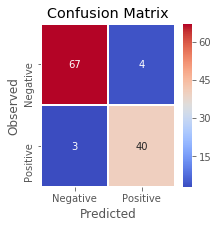

In [33]:
X_test_sc = sm.add_constant(X_test_sc)
probs_LogReG = LogReg.predict(np.asarray(X_test_sc))
threshold = 0.5
preds_LogReG = (probs_LogReG > threshold).astype(int)
Y_test = Y_test.astype('int')

print('Accuracy of Logistic Regression classifier on test set: {:0.2f}'.format(accuracy_score(preds_LogReG, Y_test))) 
print('\n')
cm_LogReg = pd.DataFrame(confusion_matrix(Y_test, preds_LogReG), index = ['Negative', 'Positive'], 
                         columns = ['Negative', 'Positive'])
f, ax = plt.subplots(figsize = (3, 3))
sns.heatmap(cm_LogReg, annot = True, linewidth = 1, cmap = 'coolwarm', ax = ax)
plt.title('Confusion Matrix')
plt.ylabel('Observed')
plt.xlabel('Predicted')
print('\n')
print('Logistic Regression Model Classification Report')
print(classification_report(Y_test, preds_LogReG))

### Regularized Lasso Logistic Regression

**Lasso (Least Absolute Shrinkage and Selection Operator)** is a regression analysis method, extended also for generalized linear models, that performs both variable selection and regularization in order to enhance the prediction accuracy and interpretability of the statistical model it produces. 

In [34]:
X_train_sc = X_train_sc.drop('const', axis = 1)
X_test_sc = X_test_sc.drop('const', axis = 1)

Lasso_Log_reg = LogisticRegression(penalty = 'l1', random_state = 42)
Lasso_Log_params = {'C':[0.01, 0.1, 1, 10, 100]}
Lasso_Log_grid = GridSearchCV(Lasso_Log_reg, Lasso_Log_params)

# Run cross validation
cv_Lasso_Log_reg = cross_val_score(Lasso_Log_grid, X_train_sc, Y_train, cv = kfold, 
                                   scoring = 'accuracy')
print('Lasso Logistic Regression Classifier Mean Accuracy Score in Cross-Validation: %0.2f \
and SD: %0.2f' %(cv_Lasso_Log_reg.mean(), cv_Lasso_Log_reg.std()))

Lasso_Log_grid.fit(X_train_sc, Y_train)

preds_Lasso_LogReg = Lasso_Log_grid.predict(X_test_sc)

print('Accuracy of Lasso Logistic Regression Classifier on test set: {:0.2f}'.format(accuracy_score(preds_Lasso_LogReg, Y_test))) 

# Check best parameters
print('Best Parameters of Lasso Logistic Regression Classifier : {}'.format(Lasso_Log_grid.best_params_))

Lasso Logistic Regression Classifier Mean Accuracy Score in Cross-Validation: 0.96 and SD: 0.03
Accuracy of Lasso Logistic Regression Classifier on test set: 0.96
Best Parameters of Lasso Logistic Regression Classifier : {'C': 1}


#### Lasso model's odds: 

In [35]:
Lasso_Log_reg_mdl = LogisticRegression(C = 1, penalty = 'l1', random_state = 42)
Lasso_Log_reg_mdl.fit(X_train_sc, Y_train)
np.exp(Lasso_Log_reg_mdl.coef_)

array([[29.41168251,  5.67221123,  3.07421933,  1.0201761 ,  0.49257732,
         1.        ,  7.83098343,  1.        ,  1.102284  ,  3.34009809,
         0.14070897,  0.62721023, 29.48329979]])

#### Compute Confusion Matrix and precision, recall, F-measure and support



Lasso Logistic Regression Model Classification Report
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

   micro avg       0.96      0.96      0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



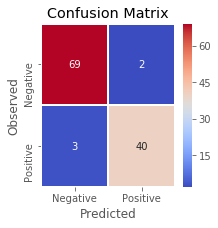

In [36]:
cm_LogReg = pd.DataFrame(confusion_matrix(Y_test, preds_Lasso_LogReg), index = ['Negative', 'Positive'], 
                         columns = ['Negative', 'Positive'])

f, ax = plt.subplots(figsize = (3, 3))
sns.heatmap(cm_LogReg, annot = True, linewidth = 1, cmap = 'coolwarm', ax = ax)
plt.title('Confusion Matrix')
plt.ylabel('Observed')
plt.xlabel('Predicted')
print('\n')
print('Lasso Logistic Regression Model Classification Report')
print(classification_report(Y_test, preds_Lasso_LogReg))

### Random Forest

**Random Forests or random decision forests** are an ensemble learning method for classification and regression that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random forests correct the decision trees’ habit of over-fitting to their training set. By using bagging (boottrap aggregation), the algorithm randomly resamples at each tree, which helps decreasing the variance of the model, without increasing the bias. In addition, Random Forests perform feature bagging too (a random subset of the features) at each candidate split. The reason is that if one or a few features are very strong predictors for our response variable, these features will be selected in many trees, causing them to become correlated.

In [37]:
RF = RandomForestClassifier(min_samples_split = 2, random_state = 42)
RF_params = {'n_estimators':[80, 150]}
RF_grid = GridSearchCV(RF, RF_params)

# Run cross validation
cv_RF = cross_val_score(RF_grid, X_train_sc, Y_train, cv = kfold, 
                                   scoring = 'accuracy')

print('Random Forest Classifier Mean Accuracy Score in Cross-Validation: %0.2f \
and SD: %0.2f' %(cv_RF.mean(), cv_RF.std()))
RF_grid.fit(X_train_sc, Y_train)

preds_RF = RF_grid.predict(X_test_sc)

print('Accuracy of Random Forest Classifier  on test set: {:0.2f}'.format(accuracy_score(preds_RF, Y_test))) 

# Check best parameters
print('Best Parameters of Random Forest Classifier : {}'.format(RF_grid.best_params_))



Random Forest Classifier Mean Accuracy Score in Cross-Validation: 0.95 and SD: 0.04
Accuracy of Random Forest Classifier  on test set: 0.94
Best Parameters of Random Forest Classifier : {'n_estimators': 150}


#### Compute Confusion Matrix and precision, recall, F-measure and support



Random Forest Model Classification Report
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        71
           1       0.93      0.91      0.92        43

   micro avg       0.94      0.94      0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



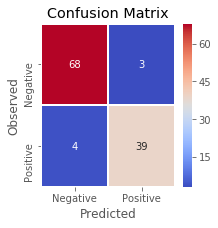

In [38]:
cm_RF = pd.DataFrame(confusion_matrix(Y_test, preds_RF), index = ['Negative', 'Positive'], 
                         columns = ['Negative', 'Positive'])

f, ax = plt.subplots(figsize = (3, 3))
sns.heatmap(cm_RF, annot = True, linewidth = 1, cmap = 'coolwarm', ax = ax)
plt.title('Confusion Matrix')
plt.ylabel('Observed')
plt.xlabel('Predicted')
print('\n')
print('Random Forest Model Classification Report')
print(classification_report(Y_test, preds_RF))

#### Random Forest Variable Importance Plot

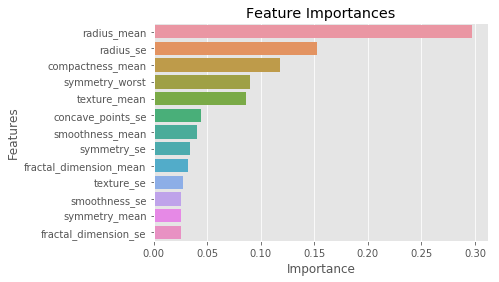

In [39]:
RF = RandomForestClassifier(n_estimators = 150, min_samples_split = 2, random_state = 42)
RF.fit(X_train_sc, Y_train)
RF_features = pd.concat([pd.Series(RF.feature_importances_), pd.Series(x.columns)], axis = 1, ignore_index = True)
RF_features.columns = ['Importance', 'Features']

# Sort in descending order 
RF_features = RF_features.sort_values(['Importance'], ascending = False)

sns.barplot(x = 'Importance', y = 'Features', data = RF_features)
plt.title('Feature Importances')
sns.set_style()
plt.show()



### Multiple Roc Curves Plot

<br>**Receiver Operating Characteristic curve or ROC curve**: is a plot of the true positive rate (sensitivity) against the false positive rate(1-specificity).
The closer the curve to the top-left border, the more accurate our Classifier is.

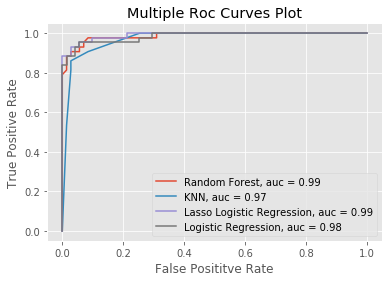

In [40]:
plt.figure(0).clf()

rfProbs = RF_grid.predict_proba(X_test_sc)[:,1]
fpr, tpr, thresh = roc_curve(Y_test, rfProbs)
auc = roc_auc_score(Y_test, rfProbs).round(2)
plt.plot(fpr, tpr, label = "Random Forest, auc = "+ str(auc))

knnProbs = KNN_grid.predict_proba(X_test_sc)[:,1]
fpr, tpr, thresh = roc_curve(Y_test, knnProbs)
auc = roc_auc_score(Y_test, knnProbs).round(2)
plt.plot(fpr, tpr, label = "KNN, auc = "+ str(auc))

lassoProbs = Lasso_Log_grid.predict_proba(X_test_sc)[:,1]
fpr, tpr, thresh = roc_curve(Y_test, lassoProbs)
auc = roc_auc_score(Y_test, lassoProbs).round(2)
plt.plot(fpr, tpr, label = "Lasso Logistic Regression, auc = "+ str(auc))

fpr, tpr, thresh = roc_curve(Y_test, probs_LogReG)
auc = roc_auc_score(Y_test, probs_LogReG).round(2)
plt.plot(fpr, tpr, label = "Logistic Regression, auc = " + str(auc))

plt.title('Multiple Roc Curves Plot')
plt.ylabel('True Positive Rate')
plt.xlabel('False Posititve Rate')
plt.legend(loc = 0)

<a id='Conclusion'></a>
### Conclusion

Since in the description file, the Acuracy score is reported, we will evaluate our classifiers via the same performance metric. Comparing the Accuracy score on test set of all 4 Classifiers, we may conclude that Lasso Classifier (accuracy score: 0.96) performs better than the others.

<a id='Future-Steps'></a>

### Future Steps 

As future steps, I would first re-create the Boxplots, so as to separate the features in subgroups of the initial groups, as now they are only useful just for a quick view.

As next steps, in terms of modelling, I would also implemement ElasticNet, Light GBM, SVM-RBF to check if the performance increases with more sophisticated models.

Additionally, in terms of feature selection, I would try also other techniques, such as: Recursive feature elimination and in terms of feature engineering: I would try removing some outliers.  

Since we have only numerical features, which are also highly correlated, I would repeat the experiment after implementing PCA dimensionality method.

Finally, instead of only implementing a fixed terms grid search for parameter-tuning, I would also experiment with optimization methods and evaluate the classifiers using a set of evaluation metrics and not just Accuracy.

ps: in terms of coding, I would turn into functions some processes, like the post-modelling evaluation phase.